In [179]:
import warnings
warnings.filterwarnings('ignore')

In [180]:
from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)

In [181]:
import os
import pandas as pd
import math
import numpy as np

Transformers

In [182]:
#! pip install wget
#! pip install transformers

In [183]:
! rm -r train/
! rm -r val/
! rm -r test/

In [184]:
TEXT_CONTENT_ACTIVITY = 'Activity'
MAX_LEN = 24

In [185]:
from tqdm.auto import tqdm  # for our loading bar
import os

def file_creation(df, column_name, folder_name, sample_size = 1000):
    text_data = []
    file_count = 0

    try:
        os.mkdir(folder_name)
    except:
        pass

    for sample in tqdm(df[column_name]):
        sample = sample.replace('\n', '')
        text_data.append(sample)
        if len(text_data) == sample_size:
            with open(f'{folder_name}/text_{str(file_count).zfill(4)}.txt', 'w', encoding='utf-8') as fp:
                fp.write('\n'.join(text_data))
            text_data = []
            file_count += 1

    with open(f'{folder_name}/text_{str(file_count).zfill(4)}.txt', 'w', encoding='utf-8') as fp:
        fp.write('\n'.join(text_data))      

Get sorted cases id

In [186]:
import wget
import os.path

if(not os.path.exists('finale.csv')):
    wget.download('https://data.4tu.nl/ndownloader/files/23993303')
    
df_finale = pd.read_csv('finale.csv', index_col=0).reset_index()

df_finale['Complete Timestamp'] = pd.to_datetime(df_finale['Complete Timestamp'])
sorted_time_cases = df_finale.sort_values('Complete Timestamp')['Case ID'].drop_duplicates().values

In [187]:
df_final = pd.read_csv('finale_time_features.csv')

In [188]:
df_final.shape

(21348, 23)

In [189]:
df_final.columns

Index(['Unnamed: 0', 'Case ID', 'Activity', 'Resource', 'Complete Timestamp',
       'Variant', 'Variant index', 'Variant.1', 'seriousness', 'customer',
       'product', 'responsible_section', 'seriousness_2', 'service_level',
       'service_type', 'support_section', 'workgroup',
       'Complete Timestamp Shift', 'Duration', 'Duration Float',
       'Time to conclusion', 'Passed Time', 'Step'],
      dtype='object')

In [190]:
just_closed = False


In [191]:
if(just_closed):
    closed_cases = []

    for name, group in df_final.groupby('Case ID'):
        last_step = group.tail(1)['Activity'].values[0]
        if(last_step == 'Closed'):
            closed_cases.append(group['Case ID'].values[0])

    df_final = df_final[df_final['Case ID'].isin(closed_cases)]     

In [192]:
df_final['Activity Cat'] = df_final['Activity'].astype('category').cat.codes

In [193]:
df_final[['Activity Cat', 'Step', 'Duration Float', 'Passed Time', 'Time to conclusion']].head(9)

,Activity Cat,Step,Duration Float,Passed Time,Time to conclusion
0,0,1,0.0000,0.0000,31.0087
1,11,2,16.0084,0.0000,15.0003
2,9,3,0.0001,15.0002,15.0002
3,1,4,15.0002,15.0003,0.0000
4,1,5,0.0000,31.0087,0.0000
5,0,1,0.0000,0.0000,30.9822
6,11,2,5.8750,25.1053,25.1072
7,9,3,0.0019,25.1072,25.1053
8,1,4,25.1053,30.9822,0.0000


In [194]:
one_hot = pd.get_dummies(df_final['Activity Cat'])

# Join the encoded df
df_final = df_final.join(one_hot)

In [195]:
from sklearn.model_selection import train_test_split

train_cases = pd.read_csv('bukhsh_data/bukhsh_remaining_time_train.csv')['case_id'].unique()
test_cases = pd.read_csv('bukhsh_data/bukhsh_remaining_time_test.csv')['case_id'].unique()

In [196]:
len(train_cases), len(test_cases)

(3664, 916)

In [197]:
print(
    df_finale[df_finale['Case ID'].isin(train_cases)]['Complete Timestamp'].min(),
    df_finale[df_finale['Case ID'].isin(train_cases)]['Complete Timestamp'].max()
)

2010-01-13 08:40:25 2014-01-03 13:20:58


In [198]:
print(
    df_finale[df_finale['Case ID'].isin(test_cases)]['Complete Timestamp'].min(),
    df_finale[df_finale['Case ID'].isin(test_cases)]['Complete Timestamp'].max()
)

2010-01-13 12:30:37 2014-01-03 10:08:18


Overriding cases checking

In [199]:
print(
    set(test_cases).intersection(set(train_cases))
)

set()


Dataframes creation

In [200]:
df_train = df_final[df_final['Case ID'].isin(train_cases)]
df_test = df_final[df_final['Case ID'].isin(test_cases)]

Text file creation

In [201]:
file_creation(df_train, TEXT_CONTENT_ACTIVITY, 'train')
file_creation(df_test, TEXT_CONTENT_ACTIVITY, 'test')

  0%|          | 0/17107 [00:00<?, ?it/s]

  0%|          | 0/4241 [00:00<?, ?it/s]

In [202]:
! ls train/ test/

test/:
text_0000.txt
text_0001.txt
text_0002.txt
text_0003.txt
text_0004.txt

train/:
text_0000.txt
text_0001.txt
text_0002.txt
text_0003.txt
text_0004.txt
text_0005.txt
text_0006.txt
text_0007.txt
text_0008.txt
text_0009.txt
text_0010.txt
text_0011.txt
text_0012.txt
text_0013.txt
text_0014.txt
text_0015.txt
text_0016.txt
text_0017.txt


Train tokenizer

In [203]:
from pathlib import Path

train_paths = [str(x) for x in Path('train').glob('**/*.txt')]
test_paths = [str(x) for x in Path('test').glob('**/*.txt')]

train_paths.sort()
test_paths.sort()

In [204]:
from tokenizers import BertWordPieceTokenizer

# initialize
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)
# and train
tokenizer.train(files=train_paths, vocab_size=MAX_LEN, min_frequency=1,
                limit_alphabet=1000, wordpieces_prefix='##',
                special_tokens=[
                    '[PAD', '[UNK]', '[CLS]', '[SEP]', '[MASK]'])

Tokenize files

In [205]:
! rm -r filiberto

In [206]:
import os

try:
    os.mkdir('./filiberto')
except:
    pass

tokenizer.save_model('filiberto')

['filiberto\\vocab.txt']

Iniatializing Tokenizer by saved model

In [207]:
##mudar o loader e deixar padrao
from transformers import RobertaTokenizer
from tokenizers import Tokenizer
from transformers import AutoTokenizer, AutoModel

from transformers import BertTokenizer

def bert_tokenize(paths, MAX_LEN):
    batch_data = []
    #tokenizer = RobertaTokenizer.from_pretrained('filiberto', max_len=MAX_LEN)
    tokenizer = BertTokenizer.from_pretrained('./filiberto')

    for path in paths:
        with open(path, 'r', encoding='utf-8') as fp:
            lines = fp.read().split('\n')

        batch = tokenizer(lines, max_length=MAX_LEN, padding='max_length', truncation=True)
        batch_data.append(pd.DataFrame(batch.input_ids))

    df_batch_data = pd.concat(batch_data, ignore_index=True)
    df_batch_data = df_batch_data.fillna(0)

    df_batch_data.columns = df_batch_data.columns.astype(str)

    return df_batch_data

In [208]:
df_train_batch_data = bert_tokenize(train_paths, MAX_LEN)
df_test_batch_data = bert_tokenize(test_paths, MAX_LEN)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [209]:
df_train_batch_data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,2,5,32,32,29,39,33,21,27,28,...,33,27,32,32,3,49,49,49,49,49
1,2,22,40,45,27,12,33,6,42,40,...,29,43,45,27,41,3,49,49,49,49
2,2,20,27,32,30,35,36,27,22,29,...,3,49,49,49,49,49,49,49,49,49
3,2,6,35,30,32,27,37,3,49,49,...,49,49,49,49,49,49,49,49,49,49
4,2,6,35,30,32,27,37,3,49,49,...,49,49,49,49,49,49,49,49,49,49


Set Correlations

<AxesSubplot:>

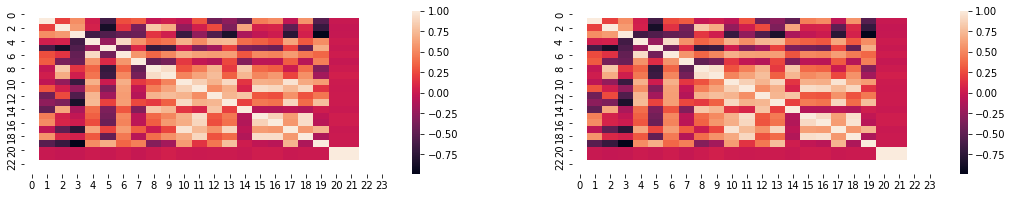

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

#plt.figure(figsize=(16, 4), dpi=80)

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(18, 3)

corr = df_train_batch_data.corr()
sns.heatmap(corr, ax=axs[0])

corr = df_test_batch_data.corr()
sns.heatmap(corr, ax=axs[1])

In [211]:
FEAT_COLS = ['Step', 'Duration Float', 'Passed Time']

In [212]:
df_train_batch_data = df_train_batch_data.reset_index()
df_test_batch_data = df_test_batch_data.reset_index()

df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [213]:
for col in FEAT_COLS:
    df_train_batch_data[col] = df_train[col]
    df_test_batch_data[col] = df_test[col]

Features selection

In [214]:
X_train = df_train_batch_data.values
y_train = df_train[['Time to conclusion']].values


X_test = df_test_batch_data.values
y_test = df_test[['Time to conclusion']].values

In [215]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

regressors = [  
        {'nome' : 'DummyRegressor', 'regressor':  DummyRegressor(strategy='mean')},
        {'nome': 'LinearRegression', 'regressor': LinearRegression(fit_intercept=False, normalize=True)},
        {'nome': 'RandomForestRegressor',  'regressor': RandomForestRegressor(n_estimators=20, criterion='mse', max_features='auto', 
                                                                              bootstrap=True, warm_start=True, max_depth=19, random_state=0)},
]

In [216]:
import time
from sklearn.metrics import mean_absolute_error

cols = [
        'Nome do modelo', 'MAE'
]

data_result = []

for regressor in regressors:    
    t1 = time.time()
    regr = regressor['regressor'].fit(X_train, y_train)
    tf = time.time()
    
    y_pred = regr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
        
    line = [
        regressor['nome'],
        mae
    ]
    data_result.append(line)

pd.DataFrame(data_result, columns=cols).sort_values(by='MAE', ascending=True)

,Nome do modelo,MAE
2,RandomForestRegressor,3.739190
1,LinearRegression,5.906196
0,DummyRegressor,14.912123


Deep learning model definition

In [217]:
import keras
from keras_self_attention import SeqSelfAttention

In [218]:
from tensorflow import keras

from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import PReLU
from keras.layers import BatchNormalization

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

In [219]:
from keras.layers.core import Activation
from keras.initializers import Constant

from keras.regularizers import l2

In [220]:
from keras_multi_head import MultiHead
from keras_multi_head import MultiHeadAttention

model = keras.models.Sequential(name='')

"""
model.add(Dense(X_train.shape[1], 
                input_dim=X_train.shape[1], 
                activation='relu', 
                name='Densa'
                ))

model.add(Dropout(0.05, name='Regularizacao'))

model.add(keras.layers.Flatten(name='Nivelamento'))
"""

model.add(LSTM(X_train.shape[1], return_sequences=False, input_shape=(X_train.shape[1], 1)))
##model.add(Bidirectional(LSTM(X_train.shape[1])))

model.add(Dropout(0.05, name='Regularizacao'))

model.add(Dense(1, activation='relu', name='Saida'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 28)                3360      
                                                                 
 Regularizacao (Dropout)     (None, 28)                0         
                                                                 
 Saida (Dense)               (None, 1)                 29        
                                                                 
Total params: 3,389
Trainable params: 3,389
Non-trainable params: 0
_________________________________________________________________


In [221]:
#model_to_dot(model)

In [222]:
nadam = keras.optimizers.Nadam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-07, name="Nadam")

model.compile(
    optimizer=nadam, 
    loss="mean_absolute_error", 
    #loss=keras.losses.LogCosh(),
    metrics=["mean_absolute_error"]
)

es = EarlyStopping(monitor='mean_absolute_error', 
                   min_delta=1e-07, #min_delta=1e-04, 
                   patience=50, verbose=1)

history = model.fit(X_train, y_train, 
                    epochs=2000,
                    batch_size=X_train.shape[1] * 100,
                    callbacks=[TqdmCallback(verbose=0), es],
                    verbose=0)

0epoch [00:00, ?epoch/s]

Epoch 54: early stopping


In [223]:
test_predicton = model.predict(X_test)
mae_error = mean_absolute_error(y_test, test_predicton)
print(mae_error)

133/133 [==============================] - 1s 4ms/step
27.811121692996938
